In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from dataclasses import dataclass

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import IPython.display as display
import matplotlib.pyplot as plt

from pathlib import Path

import random
import numpy as np
import matplotlib as mpl

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
@dataclass
class ConstParams:
    MODEL_NAME = "VGG16"

@dataclass
class HParams:
    IMAGE_HEIGHT = 224
    IMAGE_WIDTH = 224
    IMAGE_DEPTH = 3
    
    BUFFER_SIZE = 100
    BATCH_SIZE = 64
    
    SEED = 42
    RANDOM_STATE = 42
    
    NUM_EPOCH = 50
    LEARNING_RATE = 1e-5

@dataclass
class Paths:
    DATA_ROOT: Path = Path("./blur_dataset")
    CHECKPOINT_DIR: Path = Path("./checkpoint/" + ConstParams.MODEL_NAME)
    BEST_CHECKPOINT_DIR: Path = Path("./checkpoint/" + ConstParams.MODEL_NAME + "/best")
    # save (img_path, label) pairs
    TRAIN_CSV_PATH: Path = Path("./csv/train.csv")
    VAL_CSV_PATH: Path = Path("./csv/val.csv")
    TEST_CSV_PATH: Path = Path("./new_csv/test.csv")

In [3]:
tf.random.set_seed(HParams.SEED)
np.random.seed(HParams.SEED)
random.seed(HParams.SEED)

if not Path("./dataset").exists():
    Path.mkdir(Path("./dataset"))

if not Path("./checkpoint").exists():
    Path.mkdir(Path("./checkpoint"))

if not Path("./new_csv").exists():
    Path.mkdir(Path("./new_csv"))

if not Paths.CHECKPOINT_DIR.exists():
    Path.mkdir(Paths.CHECKPOINT_DIR)

if not Paths.BEST_CHECKPOINT_DIR.exists():
    Path.mkdir(Paths.BEST_CHECKPOINT_DIR)

In [4]:
# print the subfolders.
print('classes:')
for item in Paths.DATA_ROOT.iterdir():
    print(item)
    
all_image_paths = list(Paths.DATA_ROOT.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=HParams.RANDOM_STATE)
# all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif', 'bmp', 'ini')]
all_image_paths = [path for path in all_image_paths if os.path.splitext(path)[1][1:] in ('jpg', 'JPG')]

image_count = len(all_image_paths)
print('\ntotal img num:', image_count)
# print(f'all image path = {all_image_paths}')

classes:
blur_dataset\CARRIER1_Door Damage
blur_dataset\CARRIER2_Panel dents or scratches
blur_dataset\CARRIER3_Panel aging, rust or breach
blur_dataset\CARRIER4_Placards removal
blur_dataset\SHIPPER1_Floor stains, contamination or cracks
blur_dataset\SHIPPER2_Panel or Sidewall protrusion
blur_dataset\SHIPPER3_Cross member or forklift pocket overweight-deformation
blur_dataset\SHIPPER4_Panel or Sidewalls dirts_Bilateral

total img num: 4000


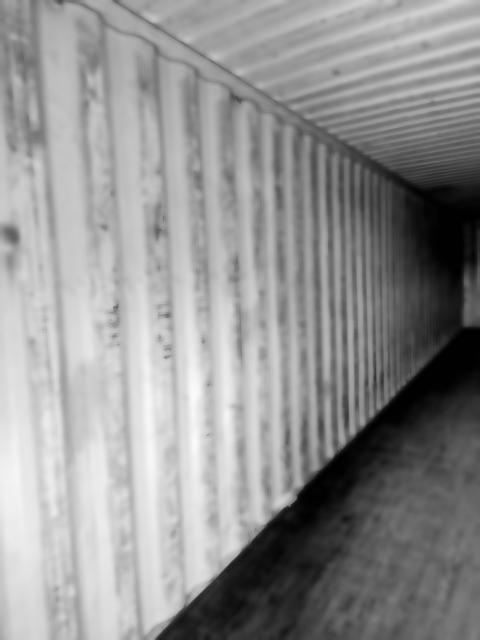

SHIPPER4_Panel or Sidewalls dirts_Bilateral


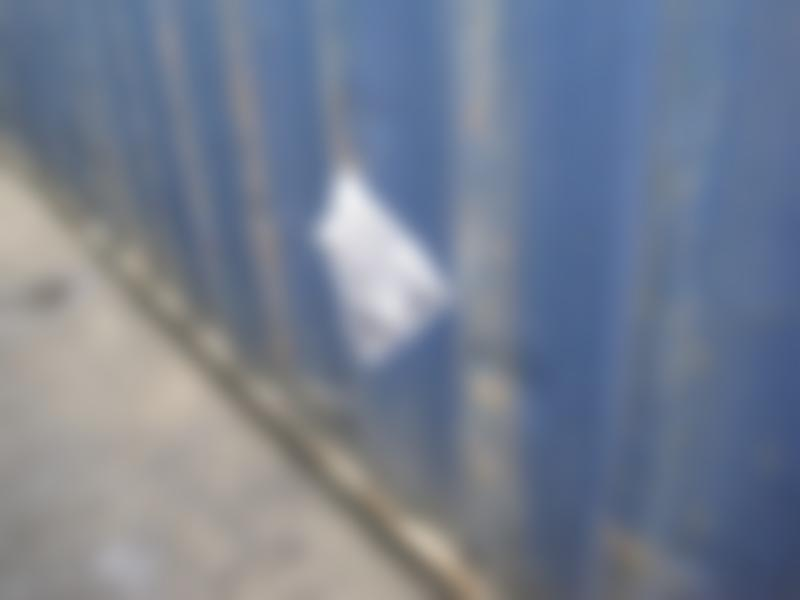

CARRIER4_Placards removal


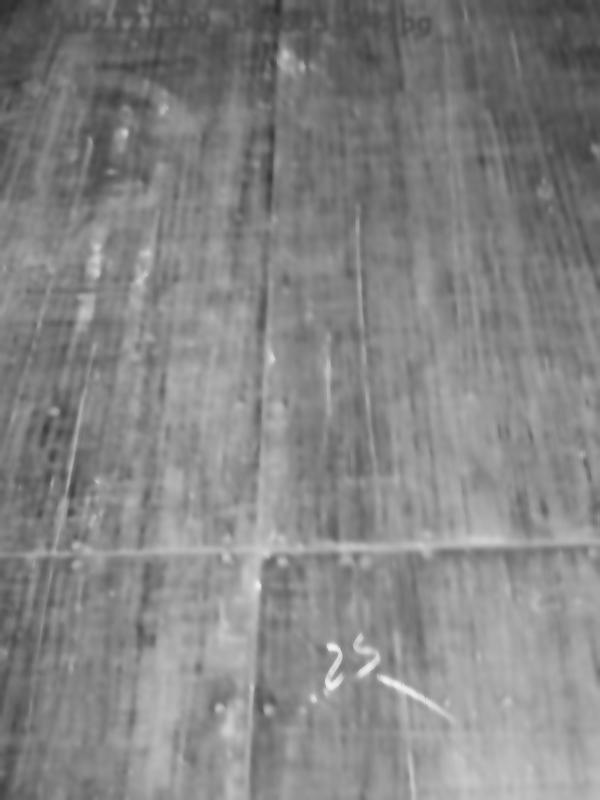

SHIPPER1_Floor stains, contamination or cracks


In [5]:
# random showing 3 iamges
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('\\')[-2])
    # print(image_path.split(os.path.sep)[-2])
    # print(image_path.split('/')[-2])

In [6]:
# get the label
label_names = sorted(item.name for item in Paths.DATA_ROOT.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

['CARRIER1_Door Damage', 'CARRIER2_Panel dents or scratches', 'CARRIER3_Panel aging, rust or breach', 'CARRIER4_Placards removal', 'SHIPPER1_Floor stains, contamination or cracks', 'SHIPPER2_Panel or Sidewall protrusion', 'SHIPPER3_Cross member or forklift pocket overweight-deformation', 'SHIPPER4_Panel or Sidewalls dirts_Bilateral']


In [7]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'CARRIER1_Door Damage': 0, 'CARRIER2_Panel dents or scratches': 1, 'CARRIER3_Panel aging, rust or breach': 2, 'CARRIER4_Placards removal': 3, 'SHIPPER1_Floor stains, contamination or cracks': 4, 'SHIPPER2_Panel or Sidewall protrusion': 5, 'SHIPPER3_Cross member or forklift pocket overweight-deformation': 6, 'SHIPPER4_Panel or Sidewalls dirts_Bilateral': 7}


In [8]:
# get the label data
all_image_label = [label_to_index[Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

First 10 label indices:  [1, 6, 1, 7, 5, 0, 3, 0, 0, 1]


In [15]:
img_path_test = all_image_paths
label_test = all_image_label

print('testing data: %d'%(len(img_path_test)))
print('testing labels: %d'%(len(label_test)))

testing data: 4000
testing labels: 4000


In [16]:
pairs_ready = False

if pairs_ready != True:
    with open(Paths.TEST_CSV_PATH, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['img_path', 'label'])
        for img_path, label in zip(img_path_test, label_test):
            writer.writerow([img_path, label])

In [17]:
class SimpleDataset(tf.data.Dataset):
    OUTPUT_SIGNATURE = (
        tf.TensorSpec(shape=(HParams.IMAGE_HEIGHT, HParams.IMAGE_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(SimpleDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        img_paths, label = open_file(filename)

        # Reading the file
        for sample_idx in range(len(img_paths)):
            img = read_file(img_paths[sample_idx])
            yield img, label[sample_idx]

    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )


In [18]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=HParams.IMAGE_DEPTH)
    img = tf.image.resize(img, (HParams.IMAGE_HEIGHT, HParams.IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_test(*args):
    return SimpleDataset(str(Paths.TEST_CSV_PATH), open_file, read_file)

In [19]:
# parse testing data
@tf.function
def map_fun_test(image, label):
    distorted_image = tf.image.per_image_standardization(image)

    return distorted_image, label

In [20]:
dataset_test = tf.data.Dataset.range(1)\
                                .interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                .batch(HParams.BATCH_SIZE, drop_remainder=True)\
                                .map(map_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                .cache()\
                                .prefetch(tf.data.AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


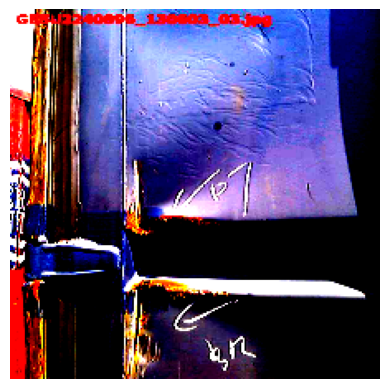

CARRIER2_Panel dents or scratches


In [21]:
for img, label in dataset_test.take(1):
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [22]:
base_model = VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=(HParams.IMAGE_HEIGHT, HParams.IMAGE_WIDTH, HParams.IMAGE_DEPTH),
                   pooling=None
                  )

# 充分利用pre-trained model的特徵提取能力，同時避免在新任務上的overfitting。
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(n_classes, activation='softmax'))

model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [24]:
# define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(HParams.LEARNING_RATE)

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [25]:
@tf.function
def test_step(image, label):
    predictions = model(image, training=False)
    loss = loss_object(label, predictions)

    return loss, label, predictions

In [26]:
checkpoint = tf.train.Checkpoint(model=model)
ckpt_manager = tf.train.CheckpointManager(
    checkpoint, Paths.CHECKPOINT_DIR, max_to_keep=3
)
best_manager = tf.train.CheckpointManager(
    checkpoint, Paths.BEST_CHECKPOINT_DIR, max_to_keep=1
)

In [27]:
true_label = []
predicted_label = []

def test_loop(dataset_test):
    print(f"Model restored from {tf.train.latest_checkpoint(Paths.BEST_CHECKPOINT_DIR)}.")
    checkpoint = tf.train.Checkpoint(model=model)
    checkpoint.restore(tf.train.latest_checkpoint(Paths.BEST_CHECKPOINT_DIR))
    
    for image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/HParams.BATCH_SIZE)):
        loss, labels, predictions = test_step(image, label)
        
        true_label.extend(labels.numpy())
        predicted_label.extend(tf.argmax(predictions, axis=1).numpy())
        
        test_loss(loss)
        test_accuracy(labels, predictions)

    template = 'Test loss: {:.4f}, Test accuracy: {:.4f}'
    tf.print(template.format(test_loss.result(), test_accuracy.result()*100))

test_loop(dataset_test)

Model restored from checkpoint\VGG16\best\ckpt-96.


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:36<00:00,  1.72it/s]

Test loss: 0.5232, Test accuracy: 81.1996


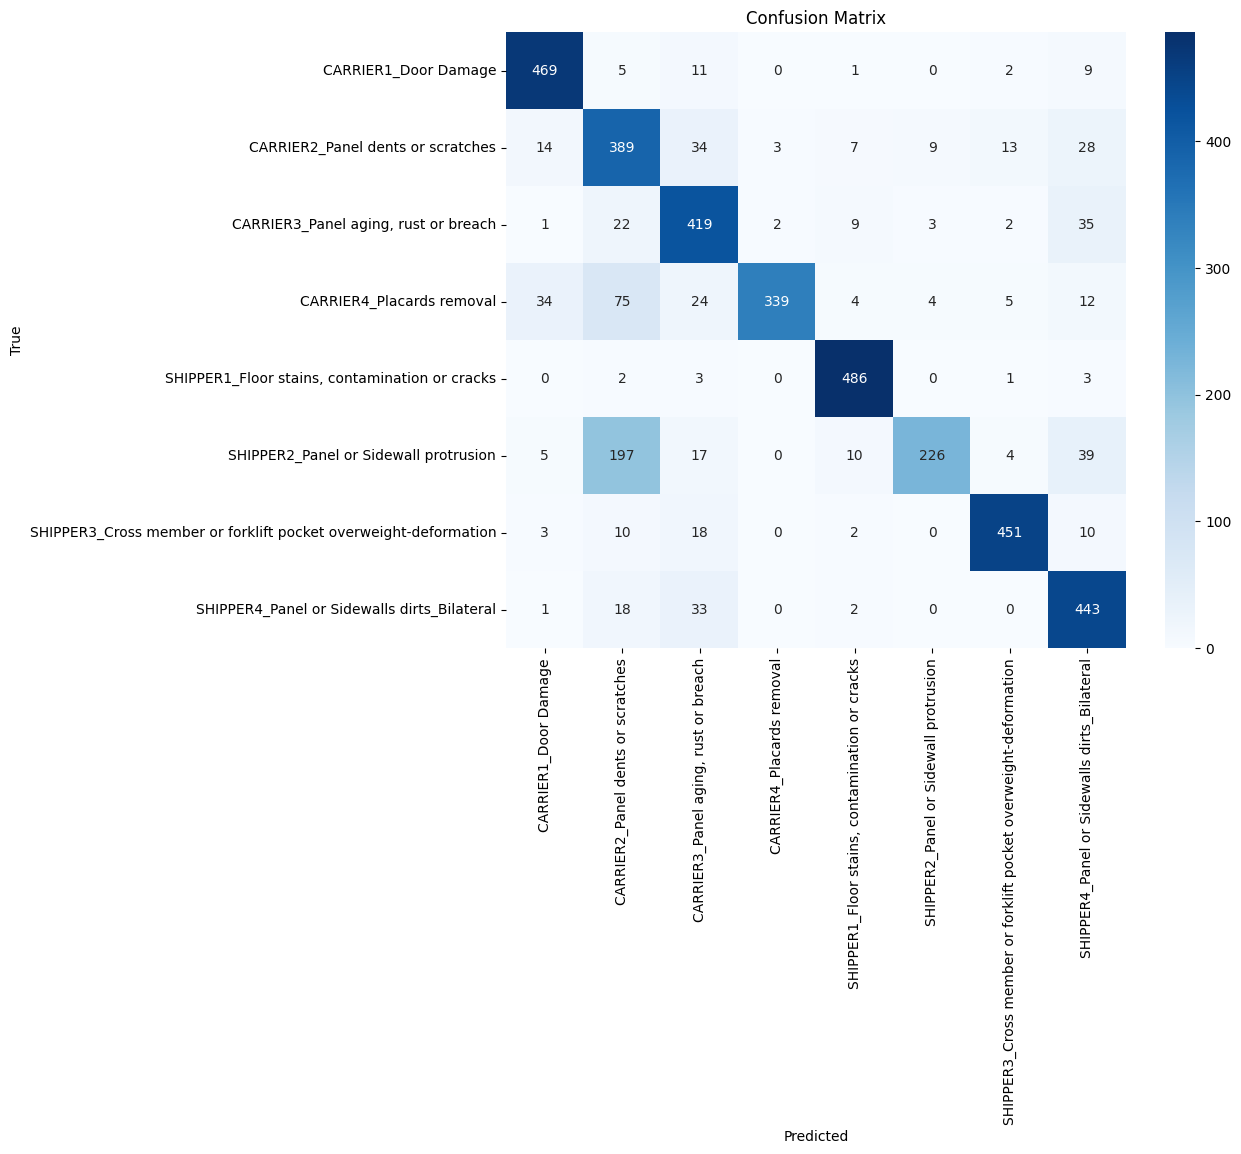

In [28]:
cm = confusion_matrix(true_label, predicted_label)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()